In [1]:
# Purpose: Preparing the pre-industrial spin-up forcing datasets. Only the 
#          SAT, RLDS and HUSS files change by -0.133°C, -0.7 W m**-2 and
#          relative humidity staying constant
#          -> the remaining variables are from the RDF (repeat decade forcing)
#             over 1962-01-01 to 1971-31-12
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 22. 04. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker
from netCDF4 import Dataset    # Note: python is case-sensitive!

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
myblue = [.19, .21, .58]

from dask.distributed import Client
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36151 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43335 Dashboard: /proxy/36151/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


### Here the HEAVY-LIFTING: Preparation of forcing fields for the pre-industrial run

-> First, create the folders and subfolders in bash where the forcing files will get stored...only then will the script work properly
> mkdir EXP_Southern_JRA55-do-1-3 \
> cd EXP_Southern_JRA55-do-1-3 \
> mkdir friver huss prra prsn psl rlds rsds tas uas vas

The relative humidity is a function of the temperature:

$$e = \frac{qp}{0.622+0.378q}$$
$$e_s(T)=e_s(T_0) \times \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) } $$

$$q_{new} = \frac{e \times (0.622)}{\left( p\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }- 0.378e \right) } $$  

So what I need are the following files: q_1962, p_1962, temp_1962, temp_1859

In [2]:
forcing = '1-3'
             #   SAT (°C), RSWD (W m**-1)
pi_offsets = [     -0.133,          -0.7]



experiment = 'EXP_PI_Offset_JRA55-do-1-3/'
# to accommodate the different forcing which has different naming conventions
if forcing == '1-3':
    base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
    fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
    version = 'gn/v20180412/'
    hrPt_timestep = ['01010000','12312230']
    hr_timestep = ['01010130','01010000']
    day_timestep = ['0101','0101']
    
    print('#########################################')    
    print('        '+experiment+'        ')
    print('#########################################')
    var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc

    a = np.linspace(1962,1972,11)

    startTime = datetime.now() # start clock     

    for i in [2,3,4]:                    # loop over the JRA55 variables that I need to change: tas, huss and rsds,          range(0,9):
        for year in range(0,10):         # loop over the first ten years, i.e., the RDF period  range(0,46):
            year_a = str(int(a[year]))
            year_aa = str(int(a[year+1]))
            startTime = datetime.now()   # start clock     
            
            print('Year ' + year_a + ' & ' + var[i])   # print year 

              

            # get correct subfolder, either 'atmos', 'land' or 'landIce'
            if var[i] == 'friver' and forcing == '1-3':
                domain = 'ocean/'
            elif var[i] == 'friver' and forcing == '1-4-0':
                domain = 'land/'
            elif var[i] == 'licalvf':
                domain = 'landIce/'
            else:
                domain = 'atmos/'

            # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
            if var[i] in ['rsds','rlds','prra','prsn']:
                res = '3hr/'
            elif var[i] in ['psl','tas','huss','uas','vas']:
                res = '3hrPt/'
            else:
                res = 'day/'
             
            # load in data for climatological RDF forcing 
            ds1 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_a + '*',combine = 'by_coords', 
                                    chunks = {'time': 1},decode_times = True) # open dataset
            
            
            # -------------------------------------------- #
            # pre-industrial offset adjustment here        #
            # -------------------------------------------- #
            if var[i] == 'tas':
                ds1['tas'] = ds1.tas + pi_offsets[0] # adjust with pre-industrial offset: substract 0.133 °C
                     
            if var[i] == 'rlds':
                ds1['rlds'] = ds1.rlds + pi_offsets[1] # adjust with pre-industrial offset: subtract 0.7 W m**-2
                
            if var[i] in ['huss']:
                # for the constant relative humidity calculation, I need RDF specific humidity, RDF sea level pressure as well as RDF and PI surface air temperature 
                huss_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
                psl_rdf = xr.open_mfdataset(base + domain + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset
                
                tas_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
                tas_rdf = xr.open_mfdataset(base + domain + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

                # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
                e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf)
                e_s_0 = 6.11*100 #Pa
                T_0 = 273.15 #K

                L = 2.5*10**6 #J/kg
                R_w = 462.52#J/kgK
                
     
                ds2 = e_rdf*0.622/(psl_rdf*np.exp(L/R_w *(1/tas_pi - 1/tas_rdf))-0.378*e_rdf)
                # load in initial file to have the correct data structure
                ds1 = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True) # open dataset
                ds1['huss'] = ds2

        # from here on save the files
        # different file names depending on the variables
            if var[i] in ['uas','vas','tas','psl','huss']:
                # construct filename for output file, e.g.
                # filename = '/g/data/e14/mv7494/HeatDist_input/EXP_tropics_JRA55-do-1-3//uas/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_197201010000-12312230.nc'
                filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
                if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                    continue                
                else: 
                    ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
            elif var[i] in ['prra','prsn','rlds','rsds']:
                filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hr_timestep[0] + '-' + year_aa + hr_timestep[1] + '.nc'
                if os.path.isfile(filename) == True:
                    continue
                else: 
                    ds1.to_netcdf(filename)
            elif var[i] == 'friver':
                if forcing == '1-3':
                    filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_aa + day_timestep[1] + '.nc'
                else:
                    filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

                if os.path.isfile(filename) == True:
                    continue
                else: 
                    ds1.to_netcdf(filename)

            # ok this works, but is missing the lat/lon/bnds fields

            print(datetime.now() - startTime) # end time of script
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
            print('') 
        # Note: Saving one month of data takes 18 seconds
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print('#########################################')    
        print('#           Variable finished           #')
        print('#########################################')

### Checking the TAS, RSDS and HUSS files if all calculations correct

### Checking if offset in TAS is correct

In [3]:
input = '/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/'
tas_rdf = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hrPt/tas/gn/v20180412/'+
                            'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc').tas[0,:,:].load() # open dataset
tas_pi = xr.open_dataset(input + 'tas/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc').tas[0,:,:].load()


(tas_rdf-tas_pi).mean(['lat','lon']).values # ok, all correct. The pre-industrial offset is 0.1329956 °C

array(0.1329956, dtype=float32)

### Checking if offset in RLDS is correct

In [4]:
rlds_rdf = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hr/rlds/gn/v20180412/'+
                            'rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010130-196301010000.nc').rlds[0,:,:].load() # open dataset
rlds_pi = xr.open_dataset(input + 'rlds/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010130-196301010000.nc').rlds[0,:,:].load()


(rlds_rdf-rlds_pi).mean(['lat','lon']).values # ok, all correct. The pre-industrial offset is 0.7 W m**-2

array(0.7000067, dtype=float32)

### Checking if relative humidity is constant

In [5]:
year_a ='1962'; res = '3hrPt/'; experiment = 'EXP_PI_Offset_JRA55-do-1-3/'
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
version = 'gn/v20180412/'
hrPt_timestep = ['01010000','12312230']; hr_timestep = ['01010130','01010000']; day_timestep = ['0101','0101']
var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc

# load in all files required
huss_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
huss_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[3] + '/' + var[3] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
psl_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

tas_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
tas_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset


In [6]:
# copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf) # water vapour pressure in RDF period
e_pi = huss_pi*psl_rdf/(0.622+0.378*huss_pi)      # water vapour pressure in PI (pre-industrial) period

e_s_0 = 6.11*100 #Pa
T_0 = 273.15 #K

L = 2.5*10**6 #J/kg
R_w = 462.52#J/kgK


e_s_rdf = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_rdf)) # saturation water vapour pressure in RDF period
e_s_pi = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_pi))   # saturation water vapour pressure in PI period

rel_humid_rdf = e_rdf/e_s_rdf # relative humidity in RDF period
rel_humid_pi = e_pi/e_s_pi    # relative humidity in PI period

Text(0.5, 1.0, 'Change in RH')

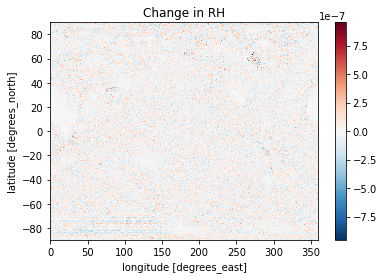

In [7]:
(rel_humid_rdf-rel_humid_pi).isel(time = 0).plot()
plt.title('Change in RH')

Note that the change in relative humidity is not exactly equal to zero because I have only used constants to 3 significant figures.

Text(0.5, 1.0, 'Relative error of change in RH')

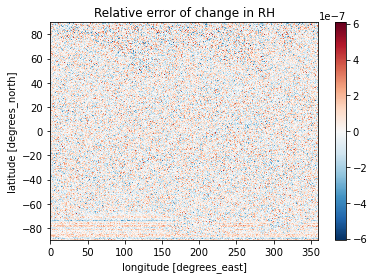

In [8]:
# relative error
((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919).plot(); plt.title('Relative error of change in RH')

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #